# ISA Hungarian Assignment BCE

**Motivation:** This is almost identical to the `ISA-Learn-Delta-warm` notebook, except now:
1. Do the Hungarian Assignment based on BCE,
2. Then minimize the loss based on L_tot = L_BCE + alpha + L_MSE.

Also, I'm going to do a warm start from the `ISA-Learn-Delta-warm` weights as of 7:50 pm, 22.10.23.

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import json, yaml, os
os.sys.path.append('../code')

from model import InvariantSlotAttention
from plotting import plot_chosen_slots
from data import make_batch
from train import hungarian_matching, comb_loss #, train

import torch
import torch.nn.functional as F

%load_ext autoreload
%autoreload 2

In [3]:
device='cuda:2'
hps = {
    'hidden_dim': 16,
    'k_slots':3,
    'query_dim':128,
    'pixel_mult':0.2,
    'device':device
}

In [4]:
m = InvariantSlotAttention(**hps).to(device)

In [5]:
cID_prev = 'isa-cosine-decay'
lastIter = 39_000
modelToLoad = f'../code/models/{cID_prev}/m_{lastIter}.pt'
m.load_state_dict(torch.load(modelToLoad,map_location=device),strict=False)

_IncompatibleKeys(missing_keys=['final_mlp.0.weight', 'final_mlp.0.bias', 'final_mlp.2.weight', 'final_mlp.2.bias'], unexpected_keys=[])

In [6]:
# Invaraint Slot Attention, Hyper Graph, warm start
cID = 'isa-hung-bce'

modelDir = f'../code/models/{cID}'
figDir = f'../code/figures/{cID}'

for d in [modelDir,figDir]:
    if not os.path.exists(d):
        os.mkdir(d)

In [8]:
def train(model, 
          Ntrain = 5000, 
          bs=32, 
          lr=3e-4,
          warmup_steps=5_000,
          alpha=1,
          losses = {'tot':[],'bce':[],'mse':[]},
          kwargs={'isRing': True, 'N_clusters':2},
          device='cpu',
          plot_every=250, 
          save_every=1000,
          color='C0',cmap='Blues',
          modelDir='.',figDir='',showImg=True):
    '''
    train -- arguments copied from Lukas's fct (see train.py)
    '''

    # Learning rate schedule config
    base_learning_rate = lr
    
    opt = torch.optim.Adam(model.parameters(), base_learning_rate)
    model.train()
    
    k_slots = model.k_slots
    max_n_rings = kwargs['N_clusters']
    resolution = model.resolution
    kwargs['device'] = device

    start = len(losses)
    for i in range(start,start+Ntrain):

        learning_rate = base_learning_rate * 0.5 * (1 + np.cos(np.pi * i / Ntrain))
        if i < warmup_steps:
            learning_rate *= (i / warmup_steps)
        
        opt.param_groups[0]['lr'] = learning_rate
        
        X, Y, mask = make_batch(N_events=bs, **kwargs)
        
        queries, att, Y_pred = model(X)
         
        # Reshape the target mask to be flat in the pixels (same shape as att)
        flat_mask = mask.reshape(-1,max_n_rings, np.prod(resolution))      
        with torch.no_grad():
            
            pairwise_cost = comb_loss(att,flat_mask,Y,Y_pred,alpha=0)
            indices = hungarian_matching(pairwise_cost)

        # Apply the sorting to the predict
        bis=torch.arange(bs).to(device)
        indices=indices.to(device)

        # Loss calc
        slots_sorted = torch.cat([att[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
        rings_sorted = torch.cat([flat_mask[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
        l_bce = F.binary_cross_entropy(slots_sorted,rings_sorted,reduction='none').sum(axis=1).mean()
        
        Y_pred_sorted = torch.cat([Y_pred[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
        Y_true_sorted = torch.cat([Y[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)

        l_mse = torch.nn.MSELoss(reduction='none')(Y_pred_sorted,Y_true_sorted).sum(axis=1).mean()
    
        # Calculate the loss
        li = l_bce + alpha*l_mse
        
        li.backward()
        clip_val=1
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_val)
        
        opt.step()
        opt.zero_grad()

        losses['tot'].append(float(li))
        losses['bce'].append(float(l_bce))
        losses['mse'].append(float(l_mse))
        
        if i % plot_every == 0:
            print('iter',i,', loss',li.detach().cpu().numpy(),', lr',opt.param_groups[0]['lr'])  
            iEvt = 0

            # losses, mask, att_img, Y_true, Y_pred
            plot_chosen_slots(losses,
                              mask[iEvt].sum(axis=0), 
                              slots_sorted[iEvt].reshape(max_n_rings,*resolution),
                              Y_true_sorted[iEvt],
                              Y_pred_sorted[iEvt])
            
        if (i % save_every == 0) and modelDir:
            torch.save(model.state_dict(), f'{modelDir}/m_{i}.pt')
            with open(f'{modelDir}/loss.json','w') as f:
                json.dump(losses, f)

    model.eval()
    return model,losses

/gpfs/slac/atlas/fs1/d/nhartman/Slot Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in true_divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


iter 100 , loss 0.1605865 , lr 2.997040092642407e-05


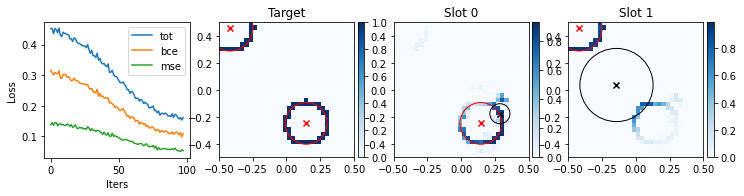

iter 200 , loss 0.12271017 , lr 5.976344103943434e-05


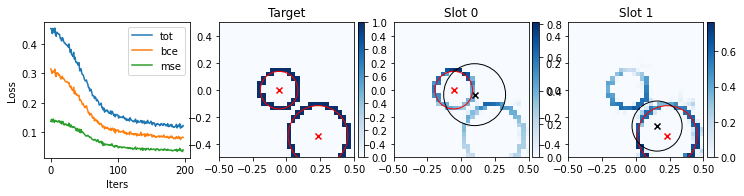

In [ ]:
m, losses = train(m, bs=256, Ntrain=5_000, warmup_steps=1_000,
                  plot_every=100, device=device,
                  modelDir=modelDir,figDir=figDir)

**Notes:**

In [ ]:
iEvt = 0

fig, ax = plt.subplots(1,3,figsize=(10,2.5))

extent = [-0.5,0.5]*2
for i_slot, (axi,li,qi) in enumerate(zip(ax,logits[iEvt],
                                         queries[iEvt].detach().numpy())):
    
    im = axi.imshow(li.reshape(32,32).detach().numpy(),
                    cmap='PuOr',vmax=.05,vmin=-.05,
                    extent=extent,origin='lower')

    divider = make_axes_locatable(axi)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

    
    axi.scatter(*qi[:2],marker='x',color='cyan')
    circle = Circle(qi[:2],np.exp(qi[2]),fill=False,color='cyan')
    axi.add_patch(circle)
        
for axi,yi in zip(ax,Y[iEvt]):
    axi.scatter(*yi[:2],marker='x',color='r')
    circle = Circle(yi[:2],yi[2],fill=False,color='r')
    axi.add_patch(circle)
    
    axi.set_xlim(-0.5,0.5)
    axi.set_ylim(-0.5,0.5)
    
plt.show()